# EXERCISE 2 - ML - Grundverfahren SS 23

Ge Li ge.li@kit.edu. This homework has 4 topics with 24 points in total.

## Submission Instructions
Submission deadline: May 31, 2023, 15:00 Berlin time. Please follow the instruction from homework ZERO!


## 1.) Probability Basics and Naive Bayes Classifier

### First Example (Two Moons)

Let us start by loading a very simple toy dataset, the "two moons".

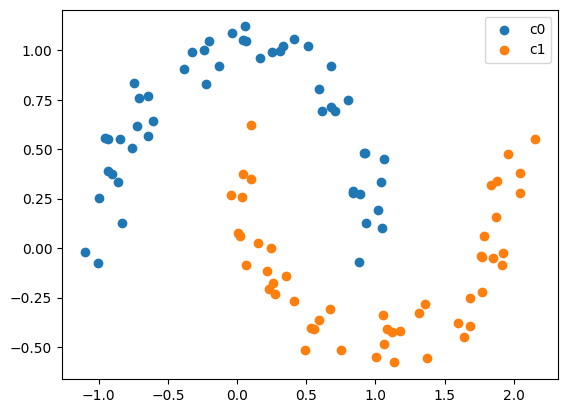

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Callable

data = dict(np.load("two_moons.npz", allow_pickle=True))
samples = data["samples"]
labels = data["labels"]

c0_samples = samples[labels == 0]  # class 0: all samples with label 0
c1_samples = samples[labels == 1]  # class 1: all samples with labe 1

plt.figure("Data")
plt.scatter(x=c0_samples[:, 0], y=c0_samples[:, 1], label="c0")
plt.scatter(x=c1_samples[:, 0], y=c1_samples[:, 1], label="c1")
plt.legend()

Let us also define some plotting utility functions.

In [46]:
def draw_2d_gaussian(mu: np.ndarray, sigma: np.ndarray, plt_std: float = 2, *args, **kwargs) -> None:
    (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(sigma)
    phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

    plt.scatter(mu[0:1], mu[1:2], marker="x", *args, **kwargs)

    a = plt_std * np.sqrt(largest_eigval)
    b = plt_std * np.sqrt(smallest_eigval)

    ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
    ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
    r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
    plt.plot(mu[0] + r_ellipse[:, 0], mu[1] + r_ellipse[:, 1], *args, **kwargs)

# plot grid for contour plots
plt_range = np.arange(-1.5, 2.5, 0.01)
plt_grid = np.stack(np.meshgrid(plt_range, plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

### Classification using Generative Models (Naive Bayes Classifier)

We first try a generative approach, the Naive Bayes Classifier.
We model the class conditional distributions $p(\boldsymbol{x}|c)$ as Gaussians, the class prior $p(c)$ as
Bernoulli and apply Bayes rule to compute the class posterior $p(c|\boldsymbol{x})$.

As a small recap, recall that the density of the Multivariate Normal Distribution is given by

$$ p(\boldsymbol{x}) = \mathcal{N}\left(\boldsymbol{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma} \right) = \dfrac{1}{\sqrt{\det \left(2 \pi \boldsymbol{\Sigma}\right)}} \exp\left( - \dfrac{(\boldsymbol{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\boldsymbol{x}-\boldsymbol{\mu})}{2}\right) $$


In [47]:
def mvn_pdf(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    """
    Density of the Multivariate Normal Distribution
    :param x: samples, shape: [N x dimension]
    :param mu: mean, shape: [dimension]
    :param sigma: covariance, shape: [dimension x dimension]
    :return p(x) with p(x) = N(mu, sigma) , shape: [N]
    """
    norm_term = 1 / np.sqrt(np.linalg.det(2 * np.pi * sigma))
    diff = x - np.atleast_2d(mu)
    exp_term = np.sum(np.linalg.solve(sigma, diff.T).T * diff, axis=-1)
    return norm_term * np.exp(-0.5 * exp_term)

**Practical Aspect:** In practice you would never implement it like that, but stay
in the log-domain. Also for numerically stable implementations of the multivariate normal density the symmetry and
positive definitness of the covariance should be exploited by working with it's Cholesky decomposition.

The maximum likelihood estimator for a Multivariate Normal Distribution is given by
$$ \boldsymbol{\mu} = \dfrac{1}{N} \sum_{i}^N \boldsymbol{x}_i \quad \quad \boldsymbol{\Sigma} = \dfrac{1}{N} \sum_{i}^N (\boldsymbol{x}_i - \boldsymbol{\mu}) (\boldsymbol{x}_i - \boldsymbol{\mu})^T. $$

This time, before we use it, we are going to derive it:

### Exercise 1.1): Derivation of Maximum Likelihood Estimator (5 Points):

Derive the maximum likelihood estimator for Multivariate Normal distributions, given above.
This derivations involves some matrix calculus.
Matrix calculus is a bit like programming, you google the stuff you need and then plug it together in the right order.
Good resources for such rules are the "matrix cookbook" (https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) and the Wikipdia article about matrix calculus
(https://en.wikipedia.org/wiki/Matrix_calculus ). State all rules you use explicitly
(except the ones given in the hints below).

**Remark** There are different conventions of how to define a gradient (as column-vector or row-vector). This results in different ways to write the Jacobian and thus different, usually transposed, matrix calculus rules:
- In the lecture we define the gradient as column-vector
- In the Wikipedia article this convention is referred to as "Denominator Layout". It also contains a nice explanation of the different conventions for the gourmets among you ;)
- The Matrix Cookbook uses the same convention (gradient as column vector)
- Please also use it here

**Hint** Here are two of those rules that might come in handy

$\dfrac{\partial\log\det(\boldsymbol{X})}{\partial \boldsymbol{X}} = \boldsymbol{X}^{-1}$

$\dfrac{\partial \boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x}}{\partial \boldsymbol{x}} = 2 \boldsymbol{A}\boldsymbol{x}$ for symmetric matrices $\boldsymbol{A}$ (Hint hint: covariance matrices are always
symmetric)

There is one missing to solve the exercise. You need to find it yourself. (Hint hint: Look in the matrix cookbook, chapter 2.2)

**Answer:**
$$L(\mu, \Sigma) = \prod \left( (2π)^{-\frac{n}{2}} * det(\Sigma)^{-\frac{1}{2}} * exp(-0.5 * \left(x_{i} - \mu)^{T} * \Sigma^{-1} * (x_{i} - \mu)\right) \right)$$
convert to log domain 

$$\log L(\mu, \Sigma) = C - 0.5 * \Sigma (x_{i} - \mu)^{T} * \Sigma^{-1} * (x_{i} - \mu)$$
partial derivations: \
for $\mu$:

$$\dfrac{\partial\log\left(L(\mu, \Sigma)\right)}{\partial\mu} = \Sigma \Sigma^{-1} * (x_{i} - \mu)$$

\begin{align*} 
    \Sigma \Sigma^{-1} * (x_{i} - \mu) = 0 \\
    \Sigma (x_{i} - \mu) = 0  \\
    \Sigma x_{i} - \Sigma \mu = 0 \\
    \Sigma x_{i} = \Sigma \mu \\
    \mu = (1/N) \Sigma x_{i}
\end{align*}

for $\Sigma$:

$$\dfrac{\partial\log\left(L(\mu, \Sigma)\right)}{\partial\Sigma} = -0.5 * \Sigma (x_{i} - \mu) * (x_{i} - \mu)^{T} * \Sigma^{-1} + 0.5 * \Sigma^{-1} $$

\begin{align*} 
    -0.5 * \Sigma (x_{i} - \mu) * (x_{i} - \mu)^{T} * \Sigma^{-1} + 0.5 * \Sigma^{-1} = 0 \\
    \Sigma (x_{i} - \mu) * (x_{i} - \mu)^{T} = \Sigma^{-1} \\
    \Sigma^{-1} = \left(\Sigma (x_{i} - \mu) * (x_{i} - \mu)^{T}\right)^{-1}
\end{align*}






**Implementation**

We use the final results from the derivation

In [48]:
def mvn_mle(x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Maximum Likelihood Estimation of parameters for Multivariate Normal Distribution
    :param x: samples shape: [N x dimension]
    :return mean (shape: [dimension]) und covariance (shape: [dimension x dimension]) that maximize likelihood of data.
    """
    mean = 1 / x.shape[0] * np.sum(x, axis=0)
    diff = x - mean
    cov = 1 / x.shape[0] * diff.T @ diff
    return mean, cov


We can now use this maximum likelihood estimator to fit generative models to the samples of both classes. Using those models and some basic rules of probability we can obtain the class conditional distribution $p(c|\boldsymbol{x})$

### Exercise 1.2) Generative Classifier (2 Points)

Given a way to fit the class conditional using our Maximum Likelihood estimator, we can implement the generative classifier

In [49]:
# Fit Gaussian Distributions using the maximum likelihood estimator to samples from both classes
mu_c0, sigma_c0 = mvn_mle(c0_samples)
mu_c1, sigma_c1 = mvn_mle(c1_samples)

# Prior obtained by "counting" samples in each class
p_c0 = c0_samples.shape[0] / samples.shape[0]
# LEAVE AS EXERCISE
p_c1 = c1_samples.shape[0] / samples.shape[0]  # = 1 - p_c0

def compute_posterior(
        samples: np.ndarray,
        p_c0: float, mu_c0: np.ndarray, sigma_c0: np.ndarray,
        p_c1: float, mu_c1: np.ndarray, sigma_c1: np.ndarray) \
        -> Tuple[np.ndarray, np.ndarray]:
    """
    computes the posteroir distribution p(c|x) given samples x, the prior p(c) and the
    class conditional likelihood p(x|c)
    :param samples: samples x to classify, shape: [N x dimension]
    :param p_c0: prior probability of class 0, p(c=0)
    :param mu_c0: mean of class conditional likelihood of class 0, p(x|c=0) shape: [dimension]
    :param sigma_c0: covariance of class conditional likelihood of class 0, p(x|c=0) shape: [dimension x dimension]
    :param p_c1: prior probability of class 1 p(c=1)
    :param mu_c1: mean of class conditional likelihood of class 1 p(x|c=1) shape: [dimension]
    :param sigma_c1: covariance of class conditional likelihood of class 1, p(x|c=1) shape: [dimension x dimension]
    :return two arrays, p(c=0|x) and p(c=1|x), both shape [N]
    """


    # TODO: compute class likelihoods
    likelihood_c0 = mvn_pdf(samples, mu_c0, sigma_c0)
    likelihood_c1 = mvn_pdf(samples, mu_c1, sigma_c1)

    # TODO: compute normalization using marginalization
    evidence = p_c0 * likelihood_c0 + p_c1 * likelihood_c1

    # TODO: compute class posterior using Bayes rule
    p_c0_given_x = (p_c0 * likelihood_c0) / evidence
    p_c1_given_x = (p_c1 * likelihood_c1) / evidence

    return p_c0_given_x, p_c1_given_x


p_c0_given_x, p_c1_given_x = compute_posterior(samples, p_c0, mu_c0, sigma_c0, p_c1, mu_c1, sigma_c1)
# Prediction
predicted_labels = np.zeros(labels.shape)
# break at 0.5 arbitrary
predicted_labels[p_c0_given_x >= 0.5] = 0.0  # is not strictly necessary since whole array already zero.
predicted_labels[p_c1_given_x > 0.5] = 1.0

# Evaluate
acc = (np.count_nonzero(predicted_labels == labels)) / labels.shape[0]
print("Accuracy:", acc)

Accuracy: 0.87


Lets look at the class likelihoods

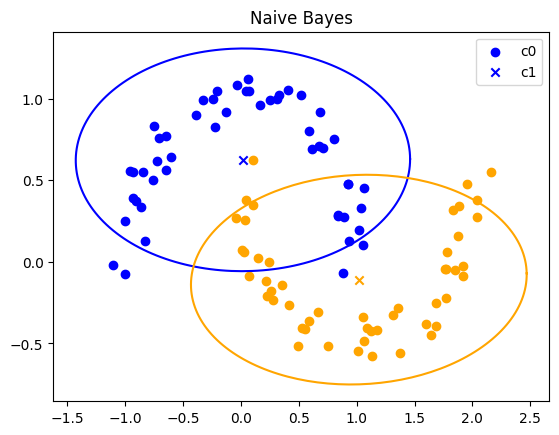

In [50]:
plt.title("Naive Bayes")
plt.scatter(x=samples[labels == 0, 0], y=samples[labels == 0, 1], c="blue")
draw_2d_gaussian(mu_c0, sigma_c0, c="blue")
plt.scatter(x=samples[labels == 1, 0], y=samples[labels == 1, 1], c="orange")
draw_2d_gaussian(mu_c1, sigma_c1, c="orange")
plt.legend(["c0", "c1"])

And the final posterior distribution for the case $p(c=1|\boldsymbol{x})$

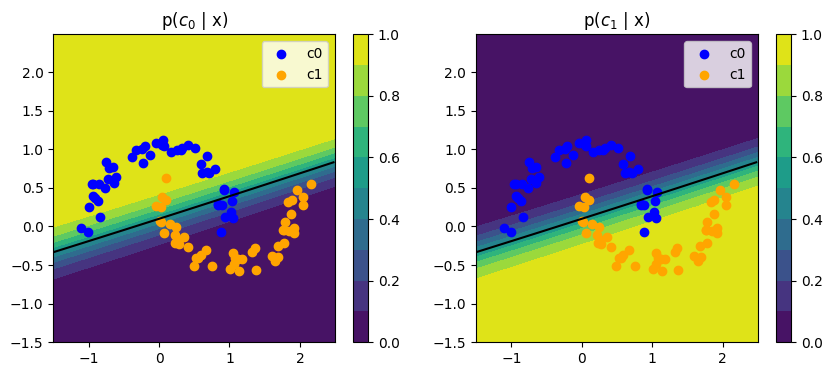

In [51]:
p_c0_given_x, p_c1_given_x = compute_posterior(flat_plt_grid, p_c0, mu_c0, sigma_c0, p_c1, mu_c1, sigma_c1)
p_c0_given_x = np.reshape(p_c0_given_x, plt_grid_shape)
p_c1_given_x = np.reshape(p_c1_given_x, plt_grid_shape)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=10)
plt.colorbar()
# plot decision boundary
plt.contour(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=[0.0, 0.5], colors=["k", "k"])

plt.title("p($c_0$ | x)")
s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])
plt.xlim(-1.5, 2.5)

plt.subplot(1, 2, 2)
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], p_c1_given_x, levels=10)
plt.colorbar()
# plot decision boundary
plt.contour(plt_grid[..., 0], plt_grid[..., 1], p_c0_given_x, levels=[0.0, 0.5], colors=["k", "k"])
plt.title("p($c_1$ | x)")
s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])

plt.xlim(-1.5, 2.5)
plt.show()

The color indicates the posterior likelihood for the respective call and the black line indicates the decision boundary.
We achieve a train accuracy of 87%.
For such a simple task that is clearly not great, but it nicely illustrates a
problem with generative approaches:
They usually depend on quite a lot of assumptions.

### Exercise 1.3) Wrong Assumptions? (1 Point):
Which untrue assumption did we make?

**Answer**

As for this data set, the assumption 'class conditional likelihoods P(x|w) are Gaussion distributed' is wrong.


## 2) Stochastic and Batch Gradients

In the recap sessions with Prof. Neumann we already saw (or will see) an implementation of a Discriminative Classifier using Logistic Regression. Here we are going to extend this to stochastic and batch gradient descent.

We start by implementing a few helper functions for affine mappings, the sigmoid function, and the negative Bernoulli log-likelihood. - Those are the same as used for the full gradient case.

In [52]:
def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs, shape: [N x sample_dim]
    :return inputs with additional bias dimension, shape: [N x feature_dim]
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

def quad_features(x: np.ndarray) -> np.ndarray:
    """
    implements quadratic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return squared features of x, shape: [N x feature_dim]
    """
    sq = np.stack([x[:, 0] ** 2, x[:, 1]**2, x[:, 0] * x[:, 1]], axis=-1)
    return np.concatenate([sq, affine_features(x)], axis=-1)

def cubic_features(x: np.ndarray) -> np.ndarray:
    """
    implements cubic feature function
    :param x: inputs, shape: [N x sample_dim]
    :return cubic features of x, shape: [N x feature_dim]
    """
    cubic = np.stack([x[:, 0]**3, x[:, 0]**2 * x[:, 1], x[:, 0] * x[:, 1]**2, x[:, 1]**3], axis=-1)
    return np.concatenate([cubic, quad_features(x)], axis=-1)

def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))

We are also using the same bernoulli objective and its gradient as before

In [53]:
def objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels))

def d_objective_bern(weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0]
    return np.squeeze(grad)

### Exercise 2.1) Implementation (3 Points)

Finally, we can implement our batch gradient descent optimizer. When setting the batch_size to 1 it will become a stochastic gradient descent optimizer.


In [54]:
def minimize_with_sgd(features: np.ndarray, labels: np.ndarray, initial_weights: np.ndarray, schedule: Callable,
                      num_iterations: int, batch_size: int):
    """
    :param features: all samples, shape: [N x feature_dim]
    :param labels: all labels, shape: [N]
    :param initial_weights: initial weights of the classifier, shape: [feature_dim * K]
    :param schedule: learning rate schedule (a callable function returning the learning rate, given the iteration
    :param num_iterations: number of times to loop over the whole dataset
    :param batch_size: size of each batch, should be between 1 and size of data
    return "argmin", "min", logging info
    """

    assert 1 <= batch_size <= features.shape[0]
    # This is a somewhat simplifying assumption but for the exercise its ok
    assert features.shape[0] % batch_size == 0, "Batch Size does not evenly divide number of samples"
    batches_per_iter = int(features.shape[0] / batch_size)

    # setup
    weights = np.zeros([batches_per_iter * num_iterations + 1, initial_weights.shape[0]])
    loss = np.zeros(batches_per_iter * num_iterations + 1)
    weights[0] = initial_weights
    loss[0]= objective_bern(weights[0], features, labels)

    for i in range(num_iterations):
        #--------------------------------------------------
        # TODO: shuffle data / get random indices
        #--------------------------------------------------
        # sample random batches for current iteration
        indices = np.random.permutation(features.shape[0])

        for j in range(batches_per_iter):

            global_idx = i * batches_per_iter + j

            #--------------------------------------------------
            # TODO: do stochastic gradient descent update!
            #--------------------------------------------------

            # Get current batches
            start_idx = j * batch_size
            end_idx = start_idx + batch_size
            batch_features = features[indices[start_idx:end_idx]]
            batch_labels = labels[indices[start_idx:end_idx]]

            # get learning rate and perform normal gradient descent step
            learning_rate = schedule(global_idx)
            gradient = d_objective_bern(weights[global_idx], batch_features, batch_labels)
            weights[global_idx + 1] = weights[global_idx] - learning_rate * gradient

            # log loss (on all samples, usually you should not use all samples to evaluate after each stochastic
            # update step)
            loss[global_idx + 1] = objective_bern(weights[global_idx + 1], features, labels)
    return weights[-1], loss[-1], (weights, loss)

The loss curve is expected to look a bit jerky due to the stochastic nature of stochastic gradient descent.
If it goes down asymptotically its fine.

Final loss 0.07769292551078903


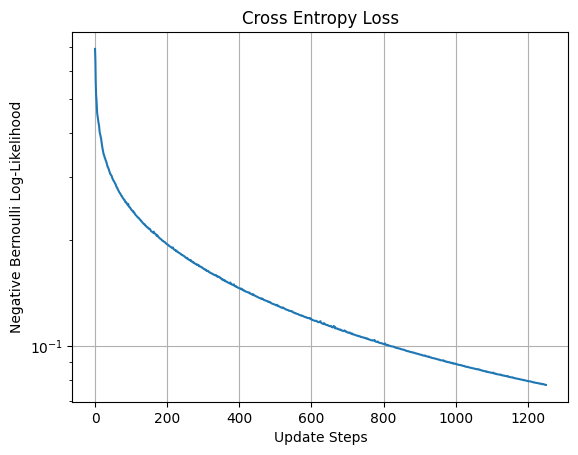

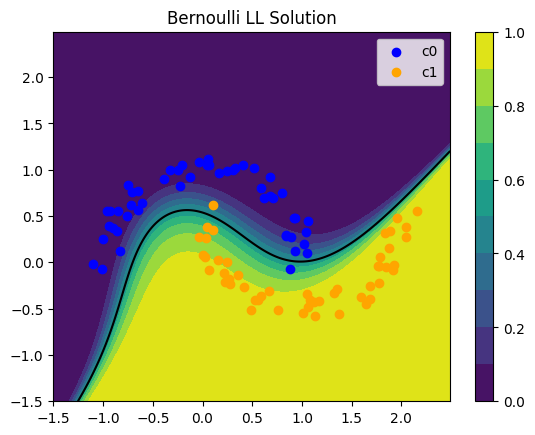

In [55]:
# Generate Features from Data

# change this to play arround with feature functions
#feature_fn = affine_features
#feature_fn = quad_features
feature_fn = cubic_features
features = feature_fn(samples)

num_iterations = 125

w_bce, l, l_info = minimize_with_sgd(features, labels, np.zeros(features.shape[1]),
                                 schedule=(lambda t: 0.25),
                                 num_iterations=num_iterations,
                                 batch_size=10)
print("Final loss", l)

plt.figure()
plt.title("Cross Entropy Loss")
plt.grid("on")
plt.xlabel("Update Steps")
plt.ylabel("Negative Bernoulli Log-Likelihood")
plt.semilogy(l_info[1])

plt.figure()
plt.title("Bernoulli LL Solution")
pred_grid = np.reshape(sigmoid(feature_fn(flat_plt_grid) @ w_bce), plt_grid_shape)

plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)
plt.colorbar()
#This is just a very hacky way to get a black line at the decision boundary:
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[0, 0.5], colors=["k"])

s0 = plt.scatter(c0_samples[..., 0], c0_samples[..., 1], color="blue")
s1 = plt.scatter(c1_samples[..., 0], c1_samples[..., 1], color="orange")
plt.legend([s0, s1], ["c0", "c1"])

### Exercise 2.2) Effect of different Batch Sizes and Number of Iterations (1. Point)
Play around with the batch size and number of iterations and briefly describe your observations about convergence speed and monotonicity  of the loss curve.

**Answer**

The monotonicity of the loss curve increases with the batch size while the convergence speed decreases.


## 3.) Multiclass Classification

The Iris Dataset is a very classical machine learning and statistics benchmark for classification, developed in the 1930's. The goal is to classify 3 types of flowers (more specifically, 3 types of flowers form the Iris species) based on 4 features: petal length, petal width, sepal length and sepal width.

As we have $K=3$ different types of flowers we are dealing with a multi-class classification problem and need to extend our sigmoid-based classifier from the previous exercise / recap session.

We will reuse our "minimize" and "affine feature" functions. Those are exactly as before. The affine features are sufficient here.

In [56]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestRegressor
from typing import Callable, Tuple

warnings.filterwarnings('ignore')

def minimize(f: Callable , df: Callable, x0: np.ndarray, lr: float, num_iters: int) -> \
        Tuple[np.ndarray, float, np.ndarray, np.ndarray]:
    """
    :param f: objective function
    :param df: gradient of objective function
    :param x0: start point, shape [dimension]
    :param lr: learning rate
    :param num_iters: maximum number of iterations
    :return argmin, min, values of x for all interations, value of f(x) for all iterations
    """
    # initialize
    x = np.zeros([num_iters + 1] + list(x0.shape))
    f_x = np.zeros(num_iters + 1)
    x[0] = x0
    f_x[0] = f(x0)
    for i in range(num_iters):
        # update using gradient descent rule
        grad = df(x[i])
        x[i + 1] = x[i] - lr * grad
        f_x[i + 1] = f(x[i + 1])
    return x[i+1], f_x[i+1], x[:i+1], f_x[:i+1] # logging info for visualization


def affine_features(x: np.ndarray) -> np.ndarray:
    """
    implements affine feature function
    :param x: inputs
    :return inputs with additional bias dimension
    """
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

### Load and Prepare Data
In the original dataset the different types of flowers are labeled with $0, 1$ and $2$. The output of our classifier will be a vector with $K=3$ entries, $\begin{pmatrix}p(c=0 | \boldsymbol x) & p(c=1 | \boldsymbol x) & p(c=2 | \boldsymbol x) \end{pmatrix}$, i.e. the probability for each class that a given sample is an instance of that class, given a datapoint $\boldsymbol x$. As presented in the lecture, working with categorical (=multinomial) distributions is easiest when we represent the labels in a different form, a so called one-hot encoding. This is a vector of the length of number of classes, in this case 3, with zeros everywhere except for the entry corresponding to the class number, which is one. For the train and test data we know to which class it belongs, so the probability for that class is one and the probability for all other classes zero.

In [57]:
data = np.load("iris_data.npz")
train_samples = data["train_features"]
train_labels = data["train_labels"]
test_samples = data["test_features"]
test_labels = data["test_labels"]

train_features = affine_features(train_samples)
test_features = affine_features(test_samples)

def generate_one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """
    :param y: vector containing classes as numbers, shape: [N]
    :param num_classes: number of classes
    :return a matrix containing the labels in an one-hot encoding, shape: [N x K]
    """
    y_oh = np.zeros([y.shape[0], num_classes])

    # can be done more efficiently using numpy with
    # y_oh[np.arange(y.size), y] = 1.0
    # we use the for loop for clarity

    for i in range(y.shape[0]):
        y_oh[i, y[i]] = 1.0

    return y_oh


oh_train_labels = generate_one_hot_encoding(train_labels, 3)
oh_test_labels = generate_one_hot_encoding(test_labels, 3)

### Optimization using Gradient Descent

The multi-class generalization of the sigmoid is the softmax function. It takes an vector of length $K$ and outputs another vector of length $K$ where the $k$-th entry is given by
$$ \textrm{softmax}(\boldsymbol{x})_k = \dfrac{\exp(x_k)}{\sum_{j=1}^K \exp(x_j)}.$$
This vector contains positive elements which sum to $1$ and thus can be interpreted as parameters of a categorical distribution. Lets see how we can implement it

In [58]:
def softmax(x: np.ndarray) -> np.ndarray:
    """softmax function
    :param x: inputs, shape: [N x K]
    :return softmax(x), shape [N x K]
    """
    a = np.max(x, axis=-1, keepdims=True)
    log_normalizer = a + np.log(np.sum(np.exp(x - a), axis=-1, keepdims=True))
    return np.exp(x - log_normalizer)

**Practical Aspect:** In the above implementation of the softmax we stayed in the log-domain until the very last command.
We also used the log-sum-exp-trick (https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).
Staying in the log domain and applying the log-sum-exp-trick whenever possible is a simple way to make the implementation
numerically more robust. It does not change anything with regards to the underlying theory.

We also need to extend our loss function. Instead of the log-likelihood of a Bernoulli distribution, we now maximize the log-likelihood of a categorical distribution which, for a single sample $\boldsymbol{x}_i$, is given by
$$\log p(c_i | \boldsymbol x_i) = \sum_{k=1}^K h_{i, k} \log(p_{i,k})$$
where $\boldsymbol h_i$ denotes the one-hot encoded true label and $p_{i,k} \equiv p(c_i = k | \boldsymbol x_i)$ the class probabilities predicted by the classifier. In multiclass classification, we learn one weight vector $\boldsymbol w_k$ per class s.t. those probabilities are given by $p(c_i = k | \boldsymbol x_i) = \mathrm{softmax}(\boldsymbol w^T \boldsymbol \phi (\boldsymbol x_i))_k $.
We can now implement the (negative) log-likelihood of a categorical distribution (we use the negative log-likelihood as we will minimize the loss later on).

In [59]:
def categorical_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    cross entropy loss function
    :param predictions: class labels predicted by the classifier, shape: [N x K]
    :param labels: true class labels, shape: [N x K]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions, shape: [N]
    """
    return - np.sum(labels * np.log(predictions + epsilon), -1)


This gives us the loss for a single sample. To get the loss for all samples we will need to sum over loss for a single sample

\begin{align}
\mathcal L_{\mathrm{cat-NLL}}
=& - \sum_{i=1}^N \log p(c_i | \boldsymbol x_i) \\
=& - \sum_{i=1}^N \sum_{k=1}^K h_{i, k} \log(p_{i,k}) \\
=& - \sum_{i=1}^N  \sum_{k=1}^K h_{i, k} \log(\textrm{softmax}(\boldsymbol{w}_k^T \boldsymbol \phi(\boldsymbol{x}_i))_k)\\
=& - \sum_{i=1}^N \left(\sum_{k=1}^K h_{i,k}\boldsymbol{w}^T_k \boldsymbol \phi(\boldsymbol{x}_i) - \log \sum_{j=1}^K \exp(\boldsymbol{w}_j^T \boldsymbol \phi(\boldsymbol{x}_i))\right).
\end{align}

In order to use gradient based optimization for this, we of course also need to derive the gradient.



### Exercise 3.1) Derivation (4 Points)
Derive the gradient $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}}$ of the loss function w.r.t. the full weight vector $\boldsymbol w \equiv \begin{pmatrix} \boldsymbol w_1^T & \dots & \boldsymbol w_K^T \end{pmatrix}^T$, which is obtained by stacking the class-specific weight vectors $\boldsymbol w_k$.

**Hint 1:** Follow the steps in the derivation of the gradient of the loss for the binary classification in the lecture.

**Hint 2:** Derive the gradient not for the whole vector $\boldsymbol w$ but only for $\boldsymbol w_k$, i.e., $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}_k}$. The gradients for the individual
$\boldsymbol w_k$ can then be stacked to obtain the full gradient.

**Answer:**

We start from $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}_k} = \dfrac{\partial}{\partial \boldsymbol{w}_k} -\sum_i^{N}\sum_{k=1}^{K}h_{i,j} \boldsymbol{w}_j^T \phi (x_i) - \log \sum_{j=1}^{K} \exp(w_j^T \phi(x_i))$

Moving the derivate term inside the sum, we can see that the first sum simplifies to only include the index where $i=k$.
$= -\sum_i^{N}\dfrac{\partial}{\partial \boldsymbol{w}_k}h_{i,k} \boldsymbol{w}_k^T \phi (x_i) - \dfrac{\partial}{\partial \boldsymbol{w}_k}\log \sum_{j=1}^{K}\exp(w_j^T \phi(x_i))$

Deriving the first term and applying the chain rule once on the second term we reach:
$= -\sum_i^{N}h_{i,k}\phi (x_i) - \dfrac{1}{\sum_{j=1}^{K}\exp(w_j^T \phi(x_i))}\dfrac{\partial}{\partial \boldsymbol{w}_k}\sum_{j=1}^{K}\exp(w_j^T \phi(x_i))$

Where once again all terms are constant except where $j=k$, dropping the sum. Taking the derivate of the remaining term we reach:
$= -\sum_i^{N}h_{i,k}\phi (x_i) - \dfrac{1}{\sum_{j=1}^{K}\exp(w_j^T \phi(x_i))}\exp(w_k^T \phi(x_i)) \phi(x_i)$

Using our softmax and class probability definition and factoring out $\phi(x_i)$ we get:
$= -\sum_i^{N}(h_{i,k}-p(c_i = k | x_i)) \phi(x_i)$

For the full gradient $\dfrac{\partial \mathcal L_{\mathrm{cat-NLL}}}{\partial \boldsymbol{w}}$ the derivate for each $k$ has to be stacked



### Exercise 3.2) Implementation (3 Points)
Now that we have the formulas for the loss and its gradient, we can implement them. Fill in the function skeletons below so that they implement the loss and its gradient. Again, in praxis, it is advisable to work with the mean nll instead of the sum, as this simplifies setting the learning rate.

**Hint:** The optimizer works with vectors only. So the function get the weights as vectors in the flat_weights parameter.
Make sure you use efficient vectorized computations (no for-loops!). Thus, we reshape the weights appropriately before using them for the computations. For the gradients make sure to return
again a vector by flattening the result.

In [60]:
# objective
def objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> float:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return cross entropy loss of the classifier given the samples
    """
    num_features = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [num_features, num_classes])
    #---------------------------------------------------------------
    # TODO
    #---------------------------------------------------------------
    loss = (categorical_nll(softmax(features @ weights), labels))
    return np.mean(loss)


# derivative
def d_objective_cat(flat_weights: np.ndarray, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
    """
    :param flat_weights: weights of the classifier (as flattened vector), shape: [feature_dim * K]
    :param features: samples to evaluate objective on, shape: [N x feature_dim]
    :param labels: labels corresponding to samples, shape: [N x K]
    :return gradient of cross entropy loss of the classifier given the samples, shape: [feature_dim * K]
    """
    feature_dim = features.shape[-1]
    num_classes = labels.shape[-1]
    weights = np.reshape(flat_weights, [feature_dim, num_classes])
    #---------------------------------------------------------------
    # TODO, do not forget to flatten the gradient before returning!
    #---------------------------------------------------------------
    gradient = features.T @ -(labels - softmax(features @ weights))
    return gradient.flatten()



Finally, we can tie everything together again. Both train and test accuracy should be at least 0.9:

Final Loss: 0.21699330517335114
Train Accuracy: 0.9583333333333334 Test Accuracy: 1.0


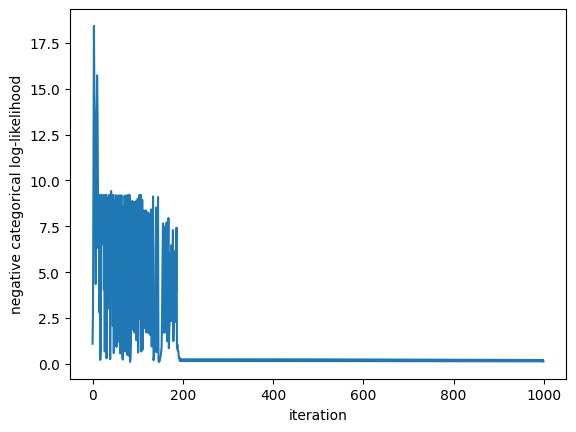

In [61]:

# optimization

w0_flat = np.zeros(5 * 3) # 4 features + bias, 3 classes
w_opt_flat, loss_opt, x_history, f_x_history = \
   minimize(lambda w: objective_cat(w, train_features, oh_train_labels),
            lambda w: d_objective_cat(w, train_features, oh_train_labels),
            w0_flat, 1e-2, 1000)

w_opt = np.reshape(w_opt_flat, [5, 3])

# plotting and evaluation
print("Final Loss:", loss_opt)
plt.figure()
plt.plot(f_x_history)
plt.xlabel("iteration")
plt.ylabel("negative categorical log-likelihood")

train_pred = softmax(train_features @ w_opt)
train_acc = np.count_nonzero(np.argmax(train_pred, axis=-1) == np.argmax(oh_train_labels, axis=-1))
train_acc /= train_labels.shape[0]
test_pred = softmax(test_features @ w_opt)
test_acc = np.count_nonzero(np.argmax(test_pred, axis=-1) == np.argmax(oh_test_labels, axis=-1))
test_acc /= test_labels.shape[0]
print("Train Accuracy:", train_acc, "Test Accuracy:", test_acc)

## 4.) Feature-Based Support Vector Machine (Hinge Loss) (5 Points)
In this exercise, we will train a feature-based SVM on the two moons dataset using the hinge loss. We will use the L-BFGS-B algorithm, provided by `scipy.optimize` for the optimization. All you need to know about this optimizer is that it is gradient-based. Otherwise, you can treat it as a black box. Yet, it's also worth a closer look if you are interested. To install scipy, use: **conda install -c conda-forge scikit-learn**

We load and visualize the data again. Note we change the label for class 0 to -1.

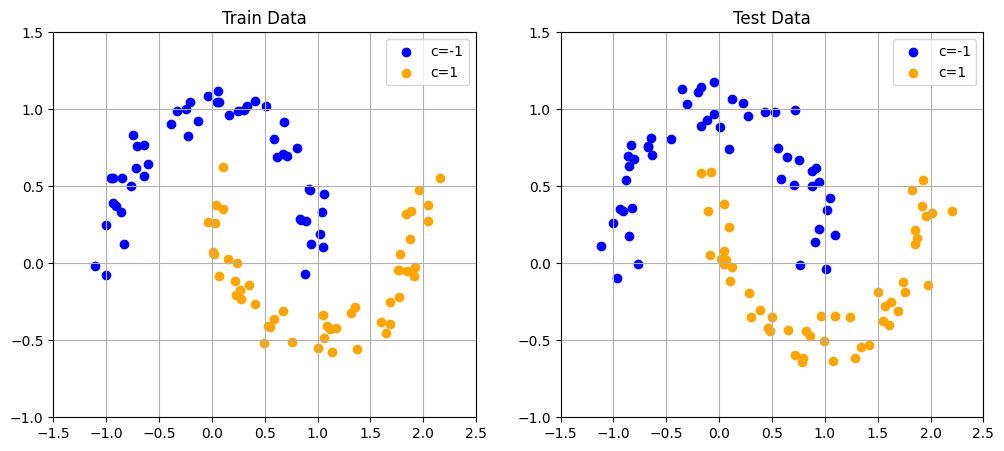

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## load data
train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM
train_labels[train_labels == 0] = -1

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM
test_labels[test_labels == 0] = -1

## plot data
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")

plt.legend()
plt.subplot(1, 2, 2)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels == -1, 0], y=test_samples[test_labels == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels == 1, 0], y=test_samples[test_labels == 1, 1], label="c=1", c="orange")

plt.legend()

For this exercise, we use cubic features $\phi(\boldsymbol x)$. Let us define a function to compute those features.

In [63]:
def cubic_feature_fn(samples: np.ndarray) -> np.ndarray:
    """
    :param x: Batch of 2D data vectors [x, y] [N x dim]
    :return cubic features: [x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, 1]
    """
    x = samples[..., 0]
    y = samples[..., 1]
    return np.stack([x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, np.ones(x.shape[0])], axis=-1)

### Exercise 4.1) Hinge Loss Objective (2 Points)

We will implement the hinge loss objective in this exercise. Its given by
 $$\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol w) = \parallel \boldsymbol{w} \parallel^2 + C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right),$$
 where $\boldsymbol{w}$ are our model parameters, $\phi(\boldsymbol{x})$ are our cubic features and the $y_i \in \lbrace{-1, 1\rbrace}$ are the class labels.

 The following function implements the hinge loss. Fill in the missing code snippets.

In [64]:
def objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> float:
    """
    objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape:[N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns svm (hinge) objective (shape: scalar)
    """
    ### TODO ###############################

    #first part
    regularization =  np.dot(weights, weights)
    #second part
    loss = slack_regularizer *np.sum(np.maximum(0, 1 - labels * np.dot(features, weights)))

    #combination
    svm_objective = regularization + loss

    return svm_objective
    ########################################

### Exercise 4.2) Hinge Loss Gradient (3 Points)
Derive and implement the gradient for the hinge loss objective stated above. For all non-differentiable points in the loss curves, you can use any valid subgradient.

**NOTE**: The derivation is explicitly part of this exercise, so state it in the file, not just implement it.


**Answer** \
\
#Kontrolle:

given:
$\nabla_{\boldsymbol{w}} (\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol w)) = \nabla_{\boldsymbol{w}} \left(\parallel \boldsymbol{w} \parallel^2 + C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right),$

the derivation is split into two steps.

Part 1: Regularization
$\nabla_{\boldsymbol{w}} (\parallel \boldsymbol{w} \parallel^2) = 2\boldsymbol{w}$

Part 2: Hinge Loss
$\nabla_{\boldsymbol{w}} \left(C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right)$
$= C \sum_i^N \nabla_{\boldsymbol{w}} \left(\max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right)$

Here we have to inspect two different cases due to the max operator:

- Case 1:    $1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) > 0$ 
  $$\nabla_{\boldsymbol{w}} \left(\max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right) = \nabla_{\boldsymbol{w}} \left(1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right) = -y_i * \phi(\boldsymbol{x}_i) $$
- Case 2:    $1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) <= 0$ 
  $$\nabla_{\boldsymbol{w}} \left(\max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right) = \nabla_{\boldsymbol{w}} \left(0\right)$$

Now we can combine the cases to get following equation:

$$C \sum_i^N \nabla_{\boldsymbol{w}} \left(\max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right)\right) = -C \sum_i^N y_i  \phi(\boldsymbol{x}_i) * \mathbb{I}(1- y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) > 0)$$

Here $\mathbb{I}(\cdot)$ an identification function that evaluates the given condition and returns true or false or rather 1 or 0 where:
$$\begin{align*}
\mathbb{I}=
  \begin{cases}
    1 \text{ if } 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) > 0 \\
    0 \text{ else}
  \end{cases}
\end{align*}$$

Finally we get the gradient by stitching the two parts togheter and arrive at the final equation:

$$\nabla_{\boldsymbol{w}} (\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol w)) = 2\boldsymbol{w}-C \sum_i^N y_i  \phi(\boldsymbol{x}_i) * \mathbb{I}(1- y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) > 0), \text{where } \begin{align*}
\mathbb{I}=
  \begin{cases}
    1 \text{ if } 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) > 0 \\
    0 \text{ else}
  \end{cases}
\end{align*}$$

In [65]:
def d_objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> np.ndarray:
    """
    gradient of objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape: [N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns gradient of svm objective (shape: [feature_dim])
    """
    ### TODO ###############################
    
    #first part
    d_reg = 2*weights

    #second part
    # Calculate the hinge loss
    loss = 1 - labels * np.dot(features, weights)

    # Find indices where hinge loss > 0
    non_zero_indices = np.where(loss > 0)[0]

    # Calculate the indicator function
    indicator = np.zeros_like(loss)
    indicator[non_zero_indices] = 1

    # Compute the gradient of the hinge loss term
    d_hinge = -slack_regularizer * np.dot(indicator * labels, features)

    # Compute the overall gradient
    svm_obj_grad = d_reg + d_hinge
    
    return svm_obj_grad
    ########################################

### Train and Evaluate
Finally, we can tie everything together and get our maximum margin classifier. Here we are using the L-BFGS-B optimizer provided by Scipy. With $C=1000$ you should end up at a training accuracy of 1 and test accuracy of 0.99, but feel free to play around with $C$.

      fun: 151.96307910040957
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 10.94673904,  -6.4965424 ,  -7.80705168,   8.78613683,
       -15.6947513 ,   0.98768257,   0.23460734,  -4.10325161,
        -3.47524588,   5.60358082])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 327
      nit: 55
     njev: 327
   status: 0
  success: True
        x: array([ 5.47336952, -3.2482712 , -3.90352584,  4.39306841, -7.84737565,
        0.49384128,  0.11730367, -2.05162581, -1.73762294,  2.80179041])
Train Accuracy:  1.0
Test Accuracy:  0.99


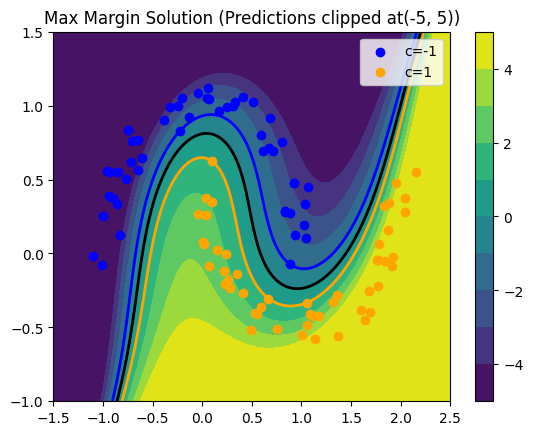

In [66]:
feature_fn = cubic_feature_fn
C = 1000.0

## optimization (for details cf. https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html)
train_features = feature_fn(train_samples)
res = opt.minimize(
    # pass objective
    fun=lambda w: objective_svm(w, train_features, train_labels, C),
    # pass initial point
    x0=np.ones(train_features.shape[-1]),
    # pass function to evaluate gradient (in scipy.opt "jac" for jacobian)
    jac=lambda w: d_objective_svm(w, train_features, train_labels, C),
    # specify method to use
    method="l-bfgs-b"
)
print(res)
w_svm = res.x

## evaluation
test_predictions = feature_fn(test_samples) @ w_svm
train_predictions = feature_fn(train_samples) @ w_svm

predicted_train_labels = np.ones(train_predictions.shape)
predicted_train_labels[train_predictions < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels == train_labels) / len(train_labels))

predicted_test_labels = np.ones(test_predictions.shape)
predicted_test_labels[test_predictions < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels == test_labels) / len(test_labels))

## plot train, contour, decision boundary and margins
plt.figure()
plt.title("Max Margin Solution (Predictions clipped at(-5, 5))")
x_plt_range = np.arange(-1.5, 2.5, 0.01)
y_plt_range = np.arange(-1, 1.5, 0.01)
plt_grid = np.stack(np.meshgrid(x_plt_range, y_plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

pred_grid = np.reshape(feature_fn(flat_plt_grid) @ w_svm, plt_grid_shape)
pred_grid = np.clip(pred_grid, -5, 5)
#plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1.0, 0.0, 1.0], colors=["blue", "black", "orange"])
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=[-1, 0, 1], colors=('blue', 'black', 'orange'),
            linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid, levels=10)

plt.colorbar()

s0 =plt.scatter(x=train_samples[train_labels == -1, 0], y=train_samples[train_labels == -1, 1], label="c=-1", c="blue")
s1 =plt.scatter(x=train_samples[train_labels == 1, 0], y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.show()